# Yammer exploratory analysis

### *Darren Tanner*

## Background

The goal of this data analysis is to identify causes of a dip in customer engagement on Yammer in the month of August. The plot in the problem prompt shows generally increasing user engagment, operationalized as the number of users who made some sort of server call in a given week, between May 1 and August 1. This is followed by a decline in user engagement during the month of August.

### Initial Hypotheses for Decline

1. **Yearly cyclic decline**: One possibility is that this is a yearly decline in user engagement due to a 'summer slump' -- i.e., users are going on vacation. Looking at a longer time series (e.g., multiple years) and accounting for seasonal/cyclic changes would be illustrative. 

    *Update after data exploration:* Unfortunately this approach (comparing yearly cycles to check whether August typically shows a downtick in engagement) is not possible with the data provided. Only engagement events between the end of April 2014 and end of August 2014 are available.
     

2. **Drop off in new users**: A change by marketing/outreach led to fewer new users coming to the platform.

3. **Sub-service bug**: Another possibility is that one of the sub-services available on Yammer (e.g., email, search, interactions, etc.) had a performance issue.

4. **Device issue**: Some device types (e.g., phones or computers) experienced login issues.

### Data Analysis Summary

The exploratory analysis below showed that the downtick in user engagements was primarily found in two areas:

1. Smartphones (and not other devices)
2. Email clickthroughs (and not email opens)

### Recommendations

This is possibly attributable to scheduled vacations in August. An analysis of yearly cycles would possibly shed light on this issue. 

More immediately:
1. The mobile platform team should identify whether any software glitches impacting use of the platform with mobile phones. 
2. The email team should identify whethere there were any content changes in the weekly digests that may have adversely affected engagement.

## Data import and initial exploration


In [17]:
# Load packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

In [72]:
#Load data
emails = pd.read_csv('../raw_data/yammer_emails.csv')
events = pd.read_csv('../raw_data/yammer_events.csv')
users = pd.read_csv('../raw_data/yammer_users.csv')

# Convert date columns to datetime
emails.occurred_at = pd.to_datetime(emails.occurred_at, infer_datetime_format=True)
events.occurred_at = pd.to_datetime(events.occurred_at, infer_datetime_format=True)
users.created_at = pd.to_datetime(users.created_at, infer_datetime_format=True)
users.activated_at = pd.to_datetime(users.activated_at, infer_datetime_format=True)

In [73]:
# Create week bins for aggregating
emails['week'] = emails.occurred_at.dt.to_period('W').dt.to_timestamp()
events['week'] = events.occurred_at.dt.to_period('W').dt.to_timestamp()
users['created_week'] = users.created_at.dt.to_period('W').dt.to_timestamp()
users['activated_week'] = users.activated_at.dt.to_period('W').dt.to_timestamp()

# Split events into engagement and signup events dfs
engagement_events = events[events.event_type == 'engagement']
signup_events = events[events.event_type == 'signup_flow']

In [4]:
# Groupby week, and count the number of unique userIDs to plot #
# engaged users per week, to eventually re-create plot from prompt
weekly_engagements = engagement_events.groupby('week').user_id.nunique().to_frame()
weekly_engagements['week'] = weekly_engagements.index
weekly_engagements.columns = ['Engagement Count', 'Week']

### Plot engagement time series

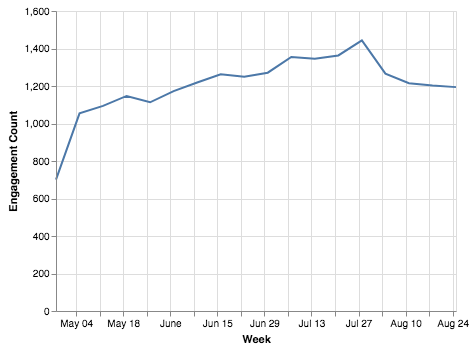

In [5]:
alt.Chart(weekly_engagements).mark_line().encode(
    x='Week',
    y='Engagement Count'
)


Above we see the downtick in August. Unfortunately the approach I had planned to take in my Hypothesis #1 is not possible to carry out, since the available data only span May-August 2014, and do not include previous years.  

### Engagement by user type

In Hypothesis #2 I conjectured that the downtick may be related to expiring free trials, and that existing users whose free trials were expiring were responsible for the downtick. If this is the case, I would expect to see the downtick in existing users (plotted above), but no downtick in new users activity.

Note that seeing a dissociation like this would not necessarily implicate free trials expiring. Confirming this would require more data and information from the marketing/outreach department who administer the free trials. But seeing a lack of change in new user signups would be informative that something in the product is driving away existing users.

In [7]:
# Get signup activity, and join it with the existing user engagement for plotting
weekly_signups = signup_events.groupby('week').user_id.nunique().to_frame()
weekly_signups['week'] = weekly_signups.index
weekly_signups.columns = ['Engagement Count', 'Week']

weekly_engagements['User Type'] = 'Existing'
weekly_signups['User Type'] = 'New'

weekly_activity = pd.concat([weekly_engagements, weekly_signups], axis = 0)
events.event_name.unique()

array(['login', 'home_page', 'like_message', 'view_inbox', 'search_run',
       'send_message', 'search_autocomplete', 'search_click_result_10',
       'create_user', 'enter_email', 'enter_info', 'complete_signup',
       'search_click_result_7', 'search_click_result_8',
       'search_click_result_1', 'search_click_result_3',
       'search_click_result_2', 'search_click_result_5',
       'search_click_result_6', 'search_click_result_9',
       'search_click_result_4'], dtype=object)

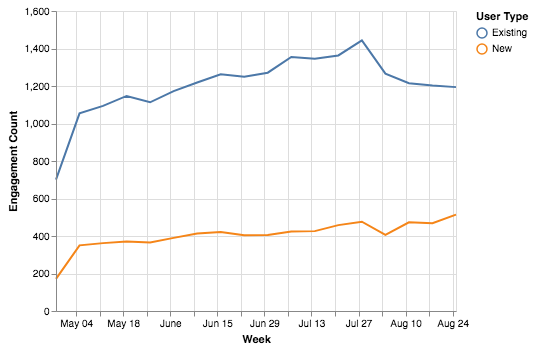

In [8]:
# Plot both unique signup engagements and existing user engagements
alt.Chart(weekly_activity).mark_line().encode(
    x='Week',
    y='Engagement Count',
    color='User Type'
)

Although existing user engagements decrease in August, new user engagements do not. The downtick is not attributable to slowing new user engagements.

### Engagements by type

First, look at the trajectory of different activity types across the time interval. If the decrease is due to specific activity types, that will help narrow the search space.

In [9]:
# Get just the 'engagement' type events (no signup) and get rid of search events
no_search = events[~events.event_name.str.startswith('search')]
no_search_signup = no_search[~no_search.event_type.str.startswith('sign')]

# Aggregate by week and look for trends
weekly_events = no_search_signup.groupby(['week', 'event_name']).user_id.nunique().to_frame().reset_index()
weekly_events.columns = ['Week', 'Event Type', 'Count']

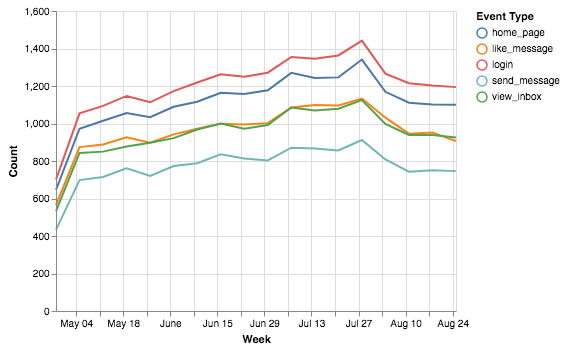

In [10]:
alt.Chart(weekly_events).mark_line().encode(
    x='Week',
    y='Count',
    color='Event Type'
)

These activities all showed generally equal downtick sizes. Plot search activities now. 

In [11]:
# Get search activities that I excluded above
searches = events[events.event_name.str.startswith('sear')]
searches = searches.groupby(['week', 'event_name']).user_id.nunique().to_frame().reset_index()
searches.columns = ['Week', 'Event Type', 'Count']

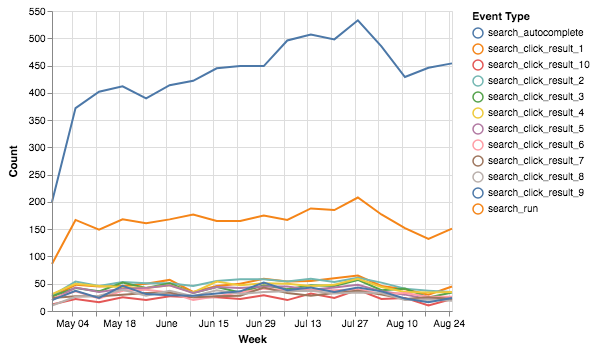

In [12]:
alt.Chart(searches).mark_line().encode(
    x='Week',
    y='Count',
    color='Event Type'
)

The two search activities with interpretable counts both showed downticks; the others don't have enough data to interpret.

Now check for signup events.

In [13]:
signup_events = events[events.event_type.str.startswith('signup')]
signup_events = signup_events.groupby(['week', 'event_name']).user_id.nunique().to_frame().reset_index()
signup_events.columns = ['Week', 'Event Type', 'Count']

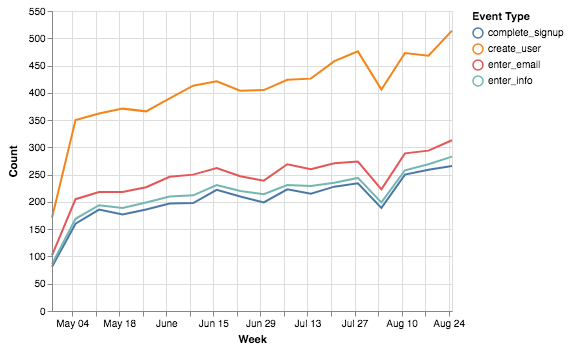

In [14]:
alt.Chart(signup_events).mark_line().encode(
    x='Week',
    y='Count',
    color='Event Type'
)

Signup events do **not** show any downtick in August, but instead show their continued upward trajectory.

### Event-type analysis summary

1. Signups continued throughout the period
2. Non-signup related activity decreased (existing users)
3. Device type could be informative

### Device type analysis

Here I will look at engagements for existing users, broken down by general device type. If there was a glitch in one of the platforms (e.g., web, mobile), that could have led to decreased engagements.

In [99]:
# Device categories
phones = ['iphone 5', 'iphone 4s', 'iphone 5s', 'nexus 7', 'nexus 5', 'amazon fire phone', 'samsung galaxy s4', 'htc one', 'nokia lumia 635', 'nexus 10']
computers = ['dell inspiron notebook', 'macbook air', 'macbook pro', 'lenovo thinkpad', 'acer aspire notebook', 'mac mini', 
            'hp pavilion desktop', 'dell inspiron desktop', 'acer aspire desktop']
tablets = ['windows surface', 'ipad mini', 'asus chromebook', 'ipad air', 'kindle fire', 'samsumg galaxy tablet', 'samsung galaxy note']

# Add column for category
engagement_events['device_category'] = ''
engagement_events.loc[engagement_events.device.isin(phones), 'device_category'] = 'phone'
engagement_events.loc[engagement_events.device.isin(computers), 'device_category'] = 'computer'
engagement_events.loc[engagement_events.device.isin(tablets), 'device_category'] = 'tablets'

# Bin by week
devices_by_week = engagement_events.groupby(['week', 'device_category']).user_id.nunique().to_frame().reset_index()
devices_by_week.columns = ['Week', 'Device Category', 'Count']

/Users/Darren/anaconda3/envs/Insight/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Darren/anaconda3/envs/Insight/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


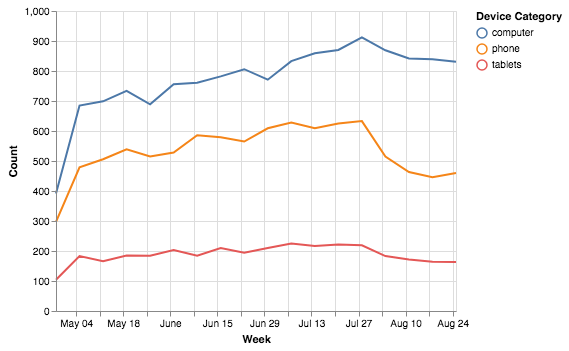

In [64]:
alt.Chart(devices_by_week).mark_line().encode(
    x='Week',
    y='Count',
    color='Device Category'
)

This graph shows a clear trend: the downtick disproportionately impacted phones. Engagements on tablets and computers flattened or slightly downtrended, but not nearly to the extent that engagements on phones did.

#### Which phones were impacted?

In [104]:
phone_engagements = engagement_events[engagement_events.device_category == 'phone']
phone_engagements_summary = phone_engagements.groupby(['week', 'device']).user_id.nunique().to_frame().reset_index()
phone_engagements_summary.columns = ['Week', 'Device', 'Count']

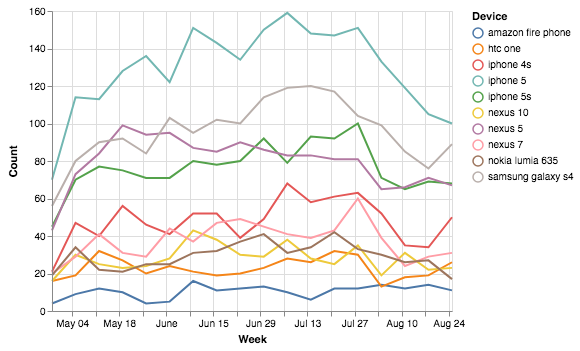

In [105]:
alt.Chart(phone_engagements_summary).mark_line().encode(
    x='Week',
    y='Count',
    color='Device'
)

This trend seems generally uniform across devices, at least for those with enough observations to be meaningful.  Devices with few observations (e.g., Amazon Fire, HTC One) don't show the same trend, but there aren't enough data for them to be interpreted easily.

### Email events

Above I found that engagements on smartphones showed a much larger dropoff than engagements on other platforms.  Here I investigate how email engagements changed over the period.

In [82]:
emails['week'] = emails.occurred_at.dt.to_period('W').dt.to_timestamp()
email_engagements = emails[emails.action.isin(['email_open', 'email_clickthrough'])]
email_engagements_summary = email_engagements.groupby(['week', 'action']).user_id.nunique().to_frame().reset_index()
email_engagements_summary.columns = ['Week', 'Action', 'Count']
email_engagements_summary.head()

,Week,Action,Count
0,2014-04-28,email_clickthrough,187
1,2014-04-28,email_open,332
2,2014-05-05,email_clickthrough,431
3,2014-05-05,email_open,910
4,2014-05-12,email_clickthrough,478


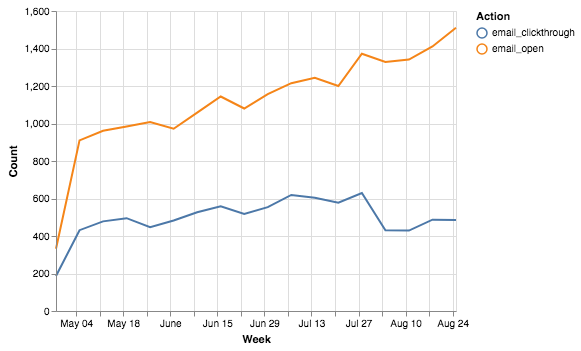

In [84]:
alt.Chart(email_engagements_summary).mark_line().encode(
    x='Week',
    y='Count',
    color='Action'
)

From this is clear that there was a significant drop off in email clickthrough to the platform, but no drop off in email opens. The number of opened emails increased throughout August, but people were not clicking through at the same rate.

**Some hypotheses for the causes of this:**
1. Vacation: August is a common time for vacation. People received emails, but did not click through because they were not at work.
2. Drop in email quality: A change in email content in August led to less overall engagement

In [106]:
emails.action.unique()

array(['sent_weekly_digest', 'email_open', 'email_clickthrough',
       'sent_reengagement_email'], dtype=object)